In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U
!pip install -q trl

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft
from peft import LoraConfig, IA3Config, get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

## **Ia3 Setup**

In [ ]:
# Freezing the model
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
# Setup IA3 Config
print(model)

config = IA3Config(
    peft_type="IA3",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): CastOutputToFloat(
    (0): Linear(in_features=768, out_features=50257, bias=False)
  )
)


/usr/local/lib/python3.10/dist-packages/peft/tuners/ia3/model.py:155: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 64512 || all params: 124504320 || trainable%: 0.051815069549393945


## **Data Loading and Tokenization**

In [ ]:
data = []
prompts = []
responses = []
only_sherlock_data = []
response_lines = []
with open("context_data_all.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            # concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            # data.append(concatenated_lines)
            promptLine = "Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \"" +  f"{lines[i].strip()}" + "\""
            responseLine = f"{lines[i+1].strip()}"
            prompts.append(promptLine)
            response_lines.append(responseLine)
            responses.append("Sherlock: " + responseLine)
            only_sherlock_data.append(responseLine)
            # data.append({"Prompt": promptLine, "Response": responseLine})
            data.append("Prompt: \n" + promptLine + "\n### Response: \n" + responseLine)

In [ ]:
print(data[0])

Prompt: 
Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. "I say, Holmes -- I wish you'd stop that caterwauling."
### Response: 
Hmpf!


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

# train_data = [tokenizer(line) for line in train_data]
# val_data = [tokenizer(line) for line in val_data]

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_dict({"text" : train_data})
val_ds = Dataset.from_dict({"text" : val_data})
print(train_ds)

Dataset({
    features: ['text'],
    num_rows: 1154
})


In [ ]:
def prompt_formatter(data):
    output_texts = []
    text = f"{data['Prompt']} \n{data['Response']}"
    output_texts.append(text)
    return output_texts

## **Training**

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-3,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.181000,3.896276
40,3.836300,3.661509
60,3.563100,3.358627
80,3.164000,3.032393
100,3.006500,2.683697
120,2.389500,2.390326
140,2.247700,2.320582
160,2.349000,2.297879
180,2.290600,2.282388
200,2.201800,2.268188


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=2.347840623855591, metrics={'train_runtime': 562.0097, 'train_samples_per_second': 28.469, 'train_steps_per_second': 1.779, 'total_flos': 944763117631488.0, 'train_loss': 2.347840623855591, 'epoch': 13.84})

## **Sampling**

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
There are several footprints in the mud outside and blood stains on the house door. Detective, do you think there was a murder inside the house?
Interrogation: Detective Holmes, you're correct. Perhaps I should take the bullet-proof vest for myself. The intruder's gone and there's a dead body."
Terrifying explanation. Detective Holmes, how could they leave that object?
Interrogation: No doubt. Mr. Holmes and I must get a quick visit to find out how he got to the house. The man who kidnapped the dog and the three others was probably a disgruntled former manager in the district. I


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A valuable artifact has been stolen from a museum, and there are no signs of forced entry. How would you deduce the method used by the thief to enter and exit undetected?
### Response: Confirm that there's no evidence to suggest that this artifact has been tampered with. The artifacts are the work of a clandestine collector, but a museum worker is responsible for them. What can the public expect of the art in this condition? Do you trust that they'll come to appreciate his efforts when he's gone? Are they willing to take up the cause of his disappearance? What should be the next step for him? If so, how will you respond to their curiosity?


In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
prompt = "A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death?"
batch = tokenizer(f"Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \n{prompt}", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=60,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Prompt: Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. 
A wealthy businessman is found dead with no apparent cause of death. The room's windows are sealed shut, and there's no sign of poison or violence. Shelock, how would you go about solving this death?
### Response: I guess we can call it a murder. We'll take the bullet-holes out of here with them. We'll call it down later. We'll find out what caused this death. Holmes, how are you doing? What do you think you are doing?
### Response: That's a long way from finding the man responsible, I'm sure. There's nothing to tell that the killer is the man I was talking about. Holmes, what does the difference between homicide


## **Graphs and Visualizations**

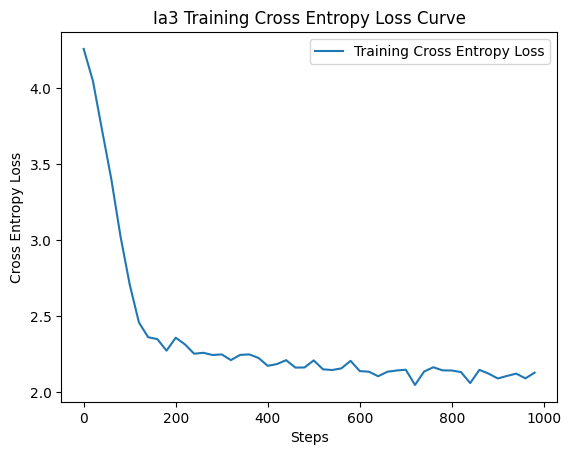

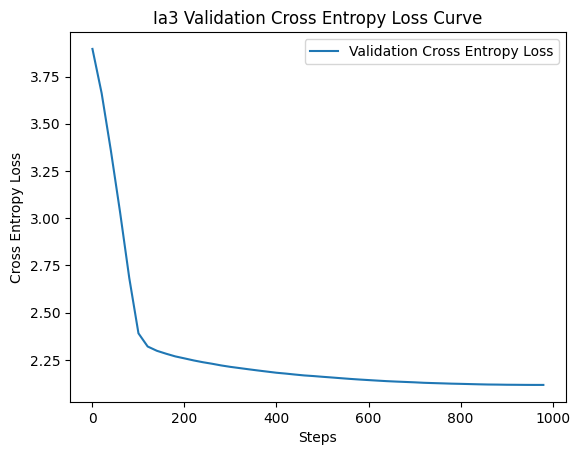

In [ ]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Ia3 Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Ia3 Validation Cross Entropy Loss Curve")
plt.legend()

In [ ]:
final_train_loss = trainer.state.log_history[-3]['loss']
final_val_loss = trainer.state.log_history[-2]['eval_loss']
print("Final train loss: ", final_train_loss)
print("Final val loss: ", final_val_loss)

Final train loss:  2.2019
Final val loss:  2.117136001586914
